# Universidade Federal de Minas Gerais 
## ICEX - Departamento de Ciência de Computação

### Quiz3 - Harris Detector
 
##### Professor Dr. Erickson R. Nascimento  
###### Aluno: Jesimon Barreto Santos - 2016070093

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

## Dados da Imagem

Apresenta-se a anotação aproximada dos pontos e a imagem 

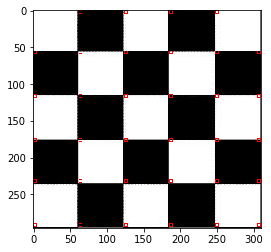

In [2]:
corners_img = [[62,0],[124,0],[185,0],[248,0],
               [0,55],[62,55],[124,55],[185,55],[248,55], [305,55],
               [0,114],[62,114],[124,114],[185,114],[248,114], [305,114],
               [0,174],[62,174],[124,174],[185,174],[248,174], [305,174],
               [0,230],[62,230],[124,230],[185,230],[248,230], [305,230],
               [0,289],[62,289],[124,289],[185,289],[248,289], [305,289],
              ]

filename = 'x_t.jpg'
img = cv2.imread(filename)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)

for cos in corners_img:
    img = cv2.rectangle(img, (cos[0],cos[1]), (cos[0]+4,cos[1]+4), (255,0,0))

plt.imshow(img)


## Nossa Implementação 

Apresenta-se a implementação seguindo a aula como refenrencia. Sobre essa implementação, um detalhe referente ao filtro gaussiano aplicado nas imagens de derivada para melhorar o resultado, caso passe o parametro como positivo. Os valores da matriz do algoritmo de detecção de quina de Harris são normalizados no final do método. Isso foi feito para facilitar a maneira de escolher o valor do limiar que indica se o R do pixel [x,y] será utilizado como borda.


1870

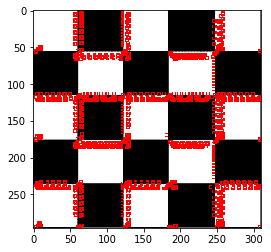

In [3]:
def my_harris_implementation(image_gray, sobel_s = 3, k = 0.04, gauss=False):
    thres_r = 0.1
    w = 3
    size_i_x, size_i_y = image_gray.shape
    
    #calculando derivada utilizando sobel
    I_x = cv2.Sobel(image_gray, cv2.CV_64F, 1, 0, ksize=sobel_s)
    I_y = cv2.Sobel(image_gray, cv2.CV_64F, 0, 1, ksize=sobel_s)
    #sum_w(I_x_2)
    
    I_x_2 = I_x ** 2
    I_y_2 = I_y ** 2
    I_x_y = np.multiply(I_x, I_y)
    
    if gauss:
        I_x_2 = cv2.GaussianBlur(I_x_2,(5, 5),1)
        I_y_2 = cv2.GaussianBlur(I_y_2,(5, 5),1)
        I_x_y = cv2.GaussianBlur(I_x_y,(5, 5),1)

    result = []
    
    for i in range(size_i_y):
        res = []
        for j in range(size_i_x):
            w_x = I_x_2[j:j+w,i:i+w]
            m_x2 = np.sum(w_x)
            w_y = I_y_2[j:j+w,i:i+w]
            m_y2 = np.sum(w_y)
            w_xy = I_x_y[j:j+w,i:i+w]
            m_xy = np.sum(w_xy)
            
            M = np.array([[m_x2,m_xy],[m_xy,m_y2]])
            
            r_w = np.linalg.det(M) - k * (np.trace(M) ** 2)
            res.append(r_w)
        result.append(res)
    
    my_harris = np.array(result)
    my_harris = my_harris/np.max(my_harris)
    return my_harris

def my_non_max_supr(harris, w = 5, thres_r = 0.5):

    size_x, size_y = harris.shape

    final = np.zeros((size_x, size_y))

    for i in range(size_y-w):
        for j in range(size_x-w):
            win = harris[j:j+w,i:i+w]
            v = np.unravel_index(win.argmax(), win.shape)
            for sy in range(i, i+w):
                for sx in range(j, j+w):
                    if (v[0] == sx - j and v[1] == sy - i and win[v[0],v[1]] > thres_r ):
                        final[sx,sy] = 1
                    else:
                        final[sx,sy] = 0
    return final
        
def search_points(final_res):
    x,y = final_res.shape
    corners = []
    for i in range(x):
        for j in range(y):
            if final_res[i,j] == 1:
                corners.append([i,j])
    return np.array(corners)


def evaluate(corners, corners_img, thres_dist = 5):   
    #calc RMS, True positive, False negative and False positive
    relation = []
    for idx, corner in enumerate(corners):
        dst_m = 100000
        posit = []
        for idy, corner_real in enumerate(corners_img):
            dst = np.sqrt(np.sum(np.square(corner - corner_real)))
            if (dst < dst_m):
                dst_m = dst
                posit = [dst,idy]
        relation.append(posit)
    
    tp = 0
    dist_g = 0
    fp = 0
    corresp = np.zeros(len(corners_img))
    for idx, dist in enumerate(relation):
        if corresp[dist[1]] != 1:
            if(dist[0] <= thres_dist):
                dist_g += dist[0]
                tp+=1
                corresp[dist[1]] = 1
            else:
                fp+=1
    
    if(tp > 0):
        rms = dist_g/tp
    else:
        rms = 0
    
    fn = len(corresp[corresp == 0])
    
    return [round(rms,4), tp, fn, fp]

def result_plot(x,y_1,y_2, evalu,label1 = 'My', label2='OpenCV'):
    plt.plot(x, y_1, label=label1)
    plt.plot(x, y_2, label=label2)

    plt.xlabel('Gaussian STD')
    plt.ylabel(evalu)
    plt.legend()
    plt.show()

    
#RUN
img = cv2.imread(filename)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
my_harris = my_harris_implementation(gray, sobel_s = 3, k = 0.04)
final_result = my_non_max_supr(my_harris, w = 5, thres_r = 0)       
corners = search_points(final_result)

for cos in corners:
    img = cv2.rectangle(img, (cos[0],cos[1]), (cos[0]+4,cos[1]+4), (255,0,0))

plt.imshow(img)
len(corners)

## Implementação da OpenCV

Apresenta-se o código da implementação do método de detecção de borda do Harris. Para um melhor comparabilidade, foram utilizados as funções de supressão máxima e pesquisa de quinas implementadas neste trabalho.

1507


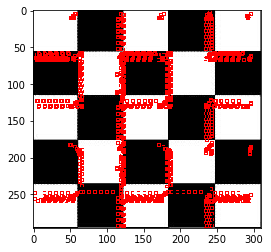

In [4]:
img = cv2.imread(filename)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# find Harris corners
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)
final_result = my_non_max_supr(dst, w = 5, thres_r = 0)       
corners = search_points(final_result)

for cos in corners:
    img = cv2.rectangle(img, (cos[0],cos[1]), (cos[0]+4,cos[1]+4), (255,0,0))

plt.imshow(img)
print(len(corners))

## Avaliação

Foi criado 7 imagens apartir da imagem apresentada no inicio deste trabalho. As 7 imagens são imagens adicionando ruído gaussiano, variando o desvio padrão. Depois, é executado os dois métodos apresentados para cada um dos casos. Essas execuções são avaliadas utilizando RMS, taxa de verdadeiro positivo, falso negativo e falso positivo. A medida RMS é calculada para toda quina predita com a quina na anotação, a mais próxima dentro de 5 pixels. As indicações de quinas que não estejam nas proximidades de nenhuma quina na anotação, são consideradas falsos positivos.

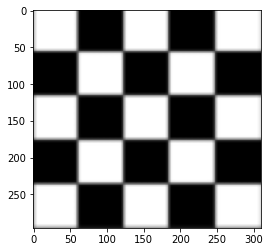

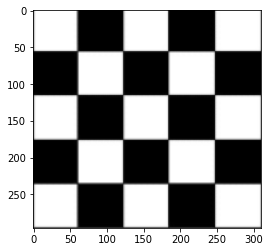

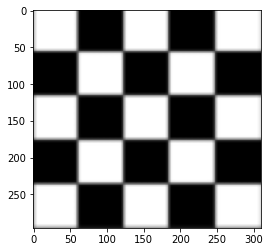

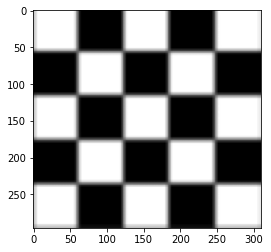

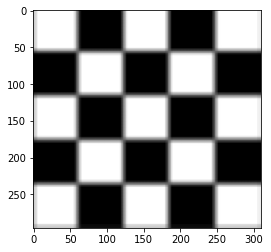

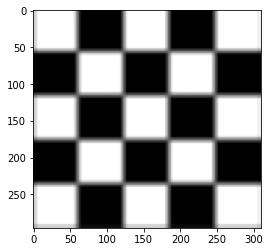

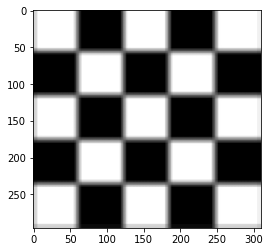

In [5]:
#aplicando ruido de vários níveis na imagem
img = cv2.imread(filename)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
imgs_noise = []
for std in range(7):
    img_noise = cv2.GaussianBlur(gray,(11, 11),std)
    imgs_noise.append(img_noise)
    plt.imshow(img_noise, cmap='gray')
    plt.show()
    

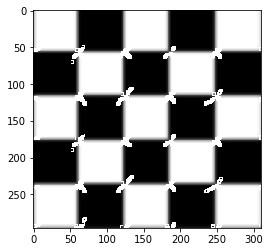

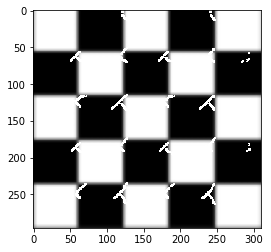

My method: [3.2654, 28, 6, 205]
Opencv method: [4.577, 13, 21, 464]


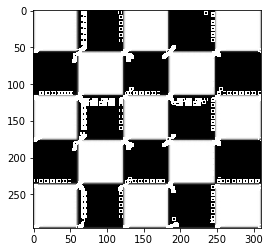

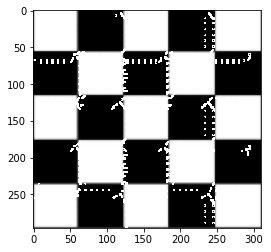

My method: [3.2164, 32, 2, 427]
Opencv method: [4.1314, 17, 17, 681]


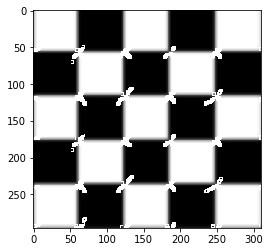

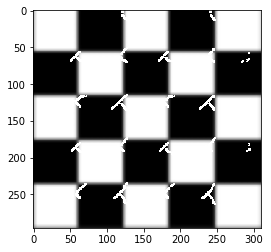

My method: [3.2654, 28, 6, 205]
Opencv method: [4.577, 13, 21, 464]


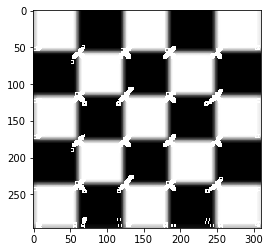

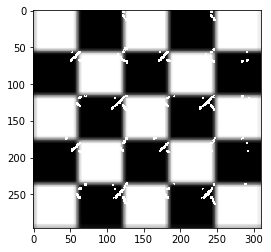

My method: [3.2159, 24, 10, 246]
Opencv method: [4.1693, 13, 21, 396]


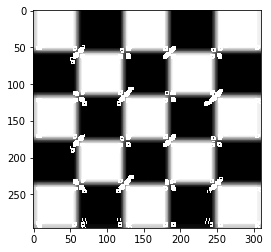

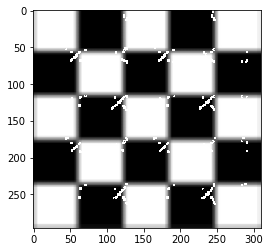

My method: [3.8356, 22, 12, 340]
Opencv method: [3.783, 12, 22, 369]


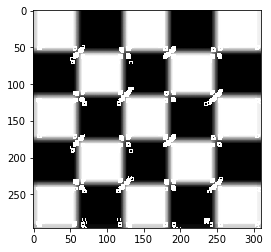

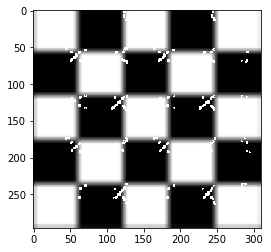

My method: [4.2072, 22, 12, 371]
Opencv method: [3.5689, 13, 21, 392]


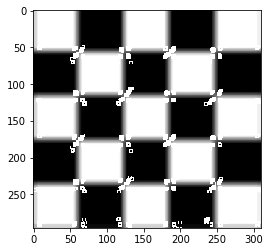

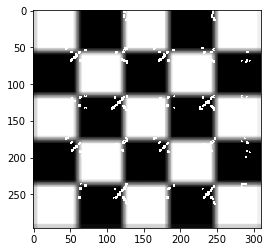

My method: [4.1153, 21, 13, 405]
Opencv method: [3.7103, 13, 21, 399]


In [6]:
my_rms = []
my_tp = []
my_fp = []
my_fn = []

cv_rms = []
cv_tp = []
cv_fp = []
cv_fn = []

for img in imgs_noise:
    my_img = img.copy()
    cv_img = img.copy()
    
    #roda o meu
    my_harris = my_harris_implementation(my_img, sobel_s = 3, k = 0.04)
    final_result = my_non_max_supr(my_harris, w = 5,thres_r = 0)       
    my_corners = search_points(final_result)

    for cos in my_corners:
        my_img = cv2.rectangle(my_img, (cos[0],cos[1]), (cos[0]+4,cos[1]+4), (255,0,0))

    plt.imshow(my_img,cmap='gray')
    plt.show()
    
    #roda o cv2
    dst = cv2.cornerHarris(cv_img,2,3,0.04)
    final_result = my_non_max_supr(dst, w = 5,thres_r = 0)       
    cv_corners = search_points(final_result)

    for cos in cv_corners:
        cv_img = cv2.rectangle(cv_img, (cos[0],cos[1]), (cos[0]+2,cos[1]+2), (255,0,0))

    plt.imshow(cv_img, cmap='gray')
    plt.show()
    
    
    
    #Evaluate
    s = evaluate(my_corners, corners_img, thres_dist = 5)
    print('My method: {}'.format(s))
    my_rms.append(s[0])
    my_tp.append(s[1])
    my_fn.append(s[2])
    my_fp.append(s[3])
    s = evaluate(cv_corners, corners_img, thres_dist = 5)
    print('Opencv method: {}'.format(s))
    cv_rms.append(s[0])
    cv_tp.append(s[1])
    cv_fn.append(s[2])
    cv_fp.append(s[3])

## Resultados

São apresentados os gráficos para cada uma das métricas apresentadas no tópico anterior. Pelos resultados, nosso método não apresentou um bom desempenho quando aplicado o ruído gaussiano, mas as quinas continuaram sendo capturadas e o resultado ficou parecido com o método da opencv. Além disso, pode-se perceber que várias indicações de quinas são mostradas no mesmo lugar da imagem, acreditamos que isso acontece devido a implementação do nosso método non_max_supre. Porém, a imagem foi retirada da internet, parece uma imagem difícil, dado que se aproximar a imagem é possivel enxergar varias quinas pequenas. Contudo, o método demonstrou um bom resultado sem ruído, como pode ser visto no tópico de implementação. Ainda, pode ser procurado um limiar melhor, entre 0 e 1. Foi observado também que nosso método demora um tempo a mais que o método da openCV.

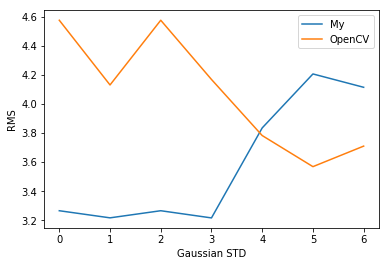

In [7]:
result_plot(list(range(len(my_rms))),my_rms,cv_rms , evalu='RMS',label1 = 'My', label2='OpenCV')

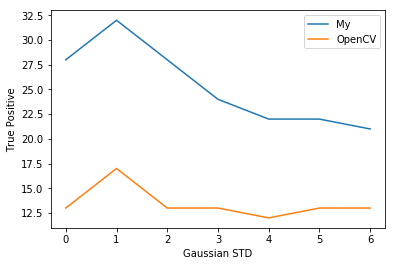

In [8]:
result_plot(list(range(len(my_tp))),my_tp,cv_tp , evalu='True Positive',label1 = 'My', label2='OpenCV')

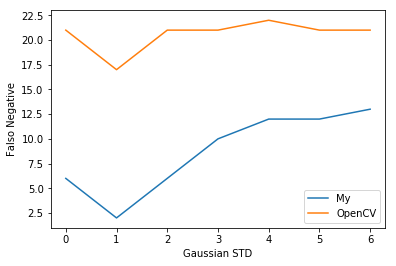

In [9]:
result_plot(list(range(len(my_fn))),my_fn,cv_fn , evalu='Falso Negative',label1 = 'My', label2='OpenCV')

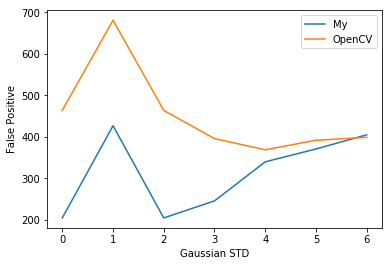

In [10]:
result_plot(list(range(len(my_fp))),my_fp,cv_fp , evalu='False Positive',label1 = 'My', label2='OpenCV')